# APPRIS vs non-APPRIS reference
 Comparision of how often the major isoform is considered the APPRIS major_isoform

Major isoform : the most abundant isoform of a gene

Minor isoforms : isoforms of a gene that are not the most abundant

APPRIS isoform : Reference isoform defined by structural and functional features
- `https://academic.oup.com/nar/article/46/D1/D213/4561658`


In [21]:



import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os
from huvec_analysis import huvec_config # parameters for plotting
import matplotlib
matplotlib.rc('font', **huvec_config.font)



# All of the plots will go into the plots folder
plot_dir = 'plot'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
# All of the stats will go into a directory
stats_dir = 'stats'
if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)


In [28]:


# file paths to the data 
sqanti_info_path = '../00_pre_analysis/220407sqanti_info/sqanti_info.tsv'
appris_file_info = '../00_pre_analysis/appris_transcripts.tsv'
human_ec_gene_file = f'{huvec_config.REFERENCE_DIRECTORY}/human_ec_genes_from_karen.txt'
gencode_human_pc_trans_path = f'{huvec_config.REFERENCE_DIRECTORY}/gencode.v38.pc_transcripts.fa'
gencode_human_all_trans_path = f'{huvec_config.REFERENCE_DIRECTORY}/gencode.v38.transcripts.fa'
protein_classification_path = f'{huvec_config.PIPELINE_RESULTS_DIRECTORY}/protein_classification/huvec_unfiltered.protein_classification.tsv'
sqanti_filtered_path = f'{huvec_config.PIPELINE_RESULTS_DIRECTORY}/sqanti3-filtered/huvec_classification.5degfilter.tsv'

# Read in HUVEC isoform information (SQANTI) into pandas table and add in annotations.
sqanti_info = pd.read_table(sqanti_info_path, index_col= False)
human_ec_genes = pd.read_table(human_ec_gene_file, header = None)[0].to_list()
appris_isonames = pd.read_table(appris_file_info)['isoname'].to_list()
protein_classification = pd.read_table(protein_classification_path)
sqanti_filtered = pd.read_table(sqanti_filtered_path)
# need to filter by 1 cpm 
sqanti_info = sqanti_info[sqanti_info['cpm']> 1]
########################################
##  #MAJOR/MINOR isoform def  #####
########################################
def mask_first(x):
    result = np.ones_like(x) 
    result[0] = 0
    return result
# get the major isoform 
def get_major_isoform(sqanti_info):
    major_isoform = sqanti_info \
        .sort_values(by = 'cpm', ascending = False) \
        .groupby(['gene']).first()\
        .reset_index()
    return major_isoform

# get the minor isoforms 
def get_minor_isoforms(sqanti_info):
    mask = sqanti_info \
        .sort_values(by = 'cpm', ascending = False) \
        .groupby(['gene'])['gene'] \
            .transform(mask_first).astype(bool)
    minor_isoforms = sqanti_info.loc[mask]
    return minor_isoforms

# for cpm threshold of 1 or higher
cpm_threshold = 1
over_N_cpm = sqanti_info[sqanti_info['cpm'] >= cpm_threshold]
# only perform the analysis for which there are multiple isoform genes 
over_N_cpm = over_N_cpm.groupby('gene').filter(lambda x: len(x) >1)
# get the cpm fraction of each isoform by gene 
gene_cpms = over_N_cpm.groupby('gene')['cpm'].sum().reset_index()
gene_cpms.columns = ['gene', 'total_gene_cpm']
over_N_cpm = over_N_cpm.merge(gene_cpms, on ='gene', how='inner')
over_N_cpm['cpm_fraction'] = over_N_cpm['cpm']/over_N_cpm['total_gene_cpm']
# merge the gene cpm and the over N cpm so we can get the fractionl abundance information for all genes 
over_N_cpm = pd.merge(over_N_cpm, gene_cpms, how = 'inner', on = 'gene')
major_isoform = get_major_isoform(over_N_cpm)
minor_isoforms = get_minor_isoforms(over_N_cpm)


In [29]:
sqanti_info

,pb_acc,len,cat,gene,transcript,cat2,fl_cts,cpm,log2cpm,fractional_abundance,protein_classification_base,ec_priority
0,PB.10.1,964,NIC,HES4,novel,intron_retention,19,7.142484,3.025469,0.195876,pNNC,0
1,PB.10.2,884,FSM,HES4,HES4-201,multi-exon,30,11.277606,3.617957,0.309278,pFSM,0
2,PB.10.3,790,FSM,HES4,HES4-204,multi-exon,4,1.503681,1.324051,0.041237,pFSM,0
3,PB.10.4,1040,FSM,HES4,HES4-203,multi-exon,44,16.540489,4.132617,0.453608,orphan_monoexon,0
6,PB.100.3,1197,FSM,NMNAT1,NMNAT1-201,multi-exon,3,1.127761,1.089336,0.157895,pFSM,0
...,...,...,...,...,...,...,...,...,...,...,...,...
84764,PB.13952.7,1504,FSM,TMLHE,TMLHE-201,multi-exon,6,2.255521,1.702889,0.120000,pFSM,0
84766,PB.13964.1,871,FSM,RPS4Y1,RPS4Y1-201,multi-exon,10,3.759202,2.250720,1.000000,pFSM,0
84767,PB.13967.1,4429,FSM,DDX3Y,DDX3Y-201,multi-exon,3,1.127761,1.089336,0.333333,pFSM,0
84768,PB.13967.2,2198,FSM,DDX3Y,DDX3Y-201,multi-exon,4,1.503681,1.324051,0.444444,pFSM,0


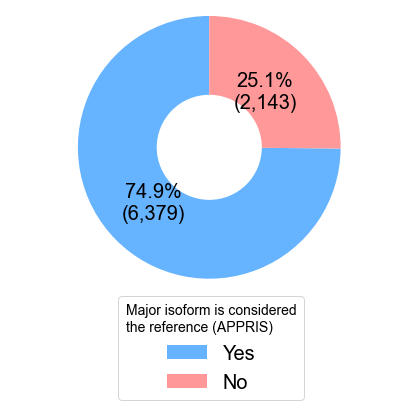

<Figure size 432x288 with 0 Axes>

In [30]:

###############################
#####  APPRIS ANALYSIS  #######
###############################
# donut chart of how many major isoforms are aligned as an appris reference
def plot_mk_donut_chart_for_appris(major_isoform, appris_isonames):
    # donut chart, how many major isoforms are appris versus non-appris (major isoform as the reference)
    # read in appris isonames (note that some genes have two isonames as best appris, both are listed here)
    
    with open('stats/01_number_major_minor_isoforms_that_match_appris.txt', 'w') as ofile:
        major_isoform['isoname'] = major_isoform['transcript'].str.replace('_', '-')
        major_isoform_is_appris = major_isoform[major_isoform['isoname'].isin(appris_isonames)]
        major_isoform_is_NOT_appris = major_isoform[~major_isoform['isoname'].isin(appris_isonames)]
        num_is_appris = major_isoform_is_appris.shape[0]
        num_is_not_appris = major_isoform_is_NOT_appris.shape[0]
        ofile.write(f'Number of major isoforms is appris:    {major_isoform_is_appris.shape[0]}\n')
        ofile.write(f'Number of major isoforms is not appris:{major_isoform_is_NOT_appris.shape[0]}')
    # appris pie / donut chart
    appris_labels = ['major isoform\nconsidered reference', 'major isoform\nnot considered reference']
    appris_sizes = [
        num_is_appris,
        num_is_not_appris,
    ]
    
    fig, ax = plt.subplots(figsize=(6,6))
    colors = ['#66b3ff','#ff9999']
    def label_donut(pct, allvals):
        absolute = round(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:,})".format(pct, absolute)
    wedges, texts, autotexts = ax.pie(appris_sizes, autopct=lambda pct: label_donut(pct, appris_sizes), colors=colors,startangle=90, textprops={'fontsize': 20})
    centre_circle = plt.Circle((0,0),0.40,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)# Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    ax.legend(wedges, ['Yes','No'], 
                title='Major isoform is considered\nthe reference (APPRIS)',
                loc="center left",
                bbox_to_anchor=(0.25, 0, 0.5, -0.4),
                fontsize=20, title_fontsize='14')
    plt.tight_layout()
    plt.savefig(f'plot/01_donut_number_of_major_appris.pdf', bbox_inches='tight')
    plt.show()
    plt.clf()
plot_mk_donut_chart_for_appris(major_isoform, appris_isonames)


In [31]:


# look at the identity of the non-priciple appris isoform 
#major_isoform['isoname'] = major_isoform['transcript'].str.replace('_', '-')
major_isoform['is_appris_principal'] = major_isoform['transcript'].isin(appris_isonames) * 1
major_isoform_is_appris = major_isoform[major_isoform['transcript'].isin(appris_isonames)]
major_isoform.to_csv('stats/02_major_isoform_list.csv')
major_isoform_is_NOT_appris = major_isoform[~major_isoform['transcript'].isin(appris_isonames)]
# drop the fractional abundance column 
major_isoform_is_NOT_appris.to_csv('stats/02_supp_table_major_iso_not_in_appris.csv', index= None)

############################
### Find the single isoforms
# see if they align with the appris reference 
############################
# make a copy of the sqanti dataframe to do some manipulations 
sqanti_copy = sqanti_info[sqanti_info['cpm']> 1]
#use the drop duplicates feature to find where there is only 1 value of the gene in the row 
genes_df  = sqanti_copy.drop_duplicates(subset = ['gene'])
# extract the transcripts from both the major and the gene list 
major_transcripts = set(major_isoform['transcript'])
all_genes = set(genes_df['transcript'])
diff = all_genes- major_transcripts
# convert the set to a list 
diff = list(diff)
single_iso = pd.DataFrame(diff)
single_iso.columns = ['single_iso_trans']
#pacbio_pr_grps['gene_list'] = pacbio_pr_grps['Gene'].str.split("|")
single_iso['gene'] = single_iso['single_iso_trans'].str.split('-').str[0]
single_iso['ec_priority'] = single_iso['gene'].isin(human_ec_genes) * 1
single_iso_in_appris = single_iso[single_iso['single_iso_trans'].isin(appris_isonames)]
single_iso_in_appris.to_csv('stats/03_single_isoform_correspponds_wAPPRIS_ref.csv')
single_iso_not_in_appris = single_iso[~single_iso['single_iso_trans'].isin(appris_isonames)]
single_iso_not_in_appris.to_csv('stats/03_single_iso_not_inAPPRISref.csv')

sqanti_genes = sqanti_info.groupby('gene').size().to_frame('size')
sqanti_genes
sqanti_genes.columns

sqanti_genes = sqanti_info.groupby('gene').size().reset_index()

sqanti_genes = sqanti_info.groupby(['gene', 'transcript']).size().reset_index(name = 'Size')


# make the supplementary table for the appris info 
appris_table = pd.read_table(appris_file_info, index_col= False)
#merge the appris info onto the sqanti info table 
merged_table = pd.merge(sqanti_info, appris_table, left_on ='transcript', right_on = 'isoname', how = 'left')
# drop the duplciated rows following the drop 
merged_table = merged_table.drop_duplicates(subset=['pb_acc'])
#send the major isoforms table to a list 
major_iso_list = major_isoform['pb_acc'].to_list()
merged_table['is_major_isoform'] = merged_table['pb_acc'].isin(major_iso_list) * 1
# rename the gene column
merged_table = merged_table.rename(columns={'gene_y': 'gene'})
#merged_table = merged_table.reset_index(drop= True, inplace= True)

# TODO index needs removed from the groupby 
supp_table_appris_info = merged_table.groupby(['gene']).apply(lambda a: a[:])
#supp_table_appris_info = supp_table_appris_info.groupby()
supp_table_appris_info.to_csv('stats/supp_table_appris_info.tsv', sep = '\t')

# keep only the rows needed for the supp table 
supp_table_appris_info_allrows = merged_table[['gene', 'transcript', 'cpm', 'is_major_isoform', 'appris_tag', 'isoname']]
supp_table_appris_info_allrows.to_csv('stats/supp_table_appris_info_all_rows.tsv', sep ='\t', index= None)



In [32]:
sqanti_info[sqanti_info['cpm']>1]

,pb_acc,len,cat,gene,transcript,cat2,fl_cts,cpm,log2cpm,fractional_abundance,protein_classification_base,ec_priority
0,PB.10.1,964,NIC,HES4,novel,intron_retention,19,7.142484,3.025469,0.195876,pNNC,0
1,PB.10.2,884,FSM,HES4,HES4-201,multi-exon,30,11.277606,3.617957,0.309278,pFSM,0
2,PB.10.3,790,FSM,HES4,HES4-204,multi-exon,4,1.503681,1.324051,0.041237,pFSM,0
3,PB.10.4,1040,FSM,HES4,HES4-203,multi-exon,44,16.540489,4.132617,0.453608,orphan_monoexon,0
6,PB.100.3,1197,FSM,NMNAT1,NMNAT1-201,multi-exon,3,1.127761,1.089336,0.157895,pFSM,0
...,...,...,...,...,...,...,...,...,...,...,...,...
84764,PB.13952.7,1504,FSM,TMLHE,TMLHE-201,multi-exon,6,2.255521,1.702889,0.120000,pFSM,0
84766,PB.13964.1,871,FSM,RPS4Y1,RPS4Y1-201,multi-exon,10,3.759202,2.250720,1.000000,pFSM,0
84767,PB.13967.1,4429,FSM,DDX3Y,DDX3Y-201,multi-exon,3,1.127761,1.089336,0.333333,pFSM,0
84768,PB.13967.2,2198,FSM,DDX3Y,DDX3Y-201,multi-exon,4,1.503681,1.324051,0.444444,pFSM,0


In [33]:
genes = sqanti_info.groupby('gene').size().reset_index(name = 'counts')
genes

,gene,counts
0,A2M,1
1,A4GALT,3
2,AAAS,4
3,AACS,4
4,AAGAB,5
...,...,...
10421,ZXDC,3
10422,ZYG11B,8
10423,ZYX,8
10424,ZZEF1,1


In [34]:
# find where the genes are = to 1 
one_gene = genes[genes['counts']==1]
one_gene

,gene,counts
0,A2M,1
15,AATF,1
16,ABAT,1
17,ABCA1,1
18,ABCA2,1
...,...,...
10405,ZSCAN29,1
10411,ZSWIM1,1
10412,ZSWIM3,1
10420,ZXDB,1
